<a href="https://colab.research.google.com/github/kryuchkovdm/Distillation/blob/master/program/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Библиотеки

In [ ]:
!pip install torch transformers pandas tqdm altair joblib sklearn

     |████████████████████████████████| 2.1MB 21.0MB/s 
     |████████████████████████████████| 901kB 50.4MB/s 
     |████████████████████████████████| 3.3MB 53.9MB/s 


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import altair as alt
from pathlib import Path
from joblib import Memory
from sklearn.metrics import f1_score
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig, DistilBertForSequenceClassification, AdamW

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from torch.utils.data import (TensorDataset,
                              DataLoader,
                              RandomSampler)

from keras.preprocessing.sequence import pad_sequences
import os
from torch.quantization import QuantStub, DeQuantStub
import random 
import matplotlib.pyplot as plt

SEED = 22
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
ROOT = Path("/content/drive/My Drive/")

if not ROOT.exists():
    from google.colab import drive
    drive.mount("/content/drive")

assert ROOT.exists()
DATA = ROOT / "data"
MODELS = ROOT / "models"

Mounted at /content/drive


In [ ]:
CACHE = ROOT / "cache/distillation"

if not CACHE.exists():
    CACHE.mkdir(parents=True)

memory = Memory(CACHE, verbose=False)

##DataSetIntents

In [ ]:
data_new = (pd.read_csv('/content/drive/My Drive/intents.csv').dropna())
data_clear = data_new.sort_values('topic').reset_index()

In [ ]:
data_new.topic.unique()

array(['GetRide', 'FindEvents', 'BuyEventTickets', 'SearchOnewayFlight',
       'SearchRoundtripFlights', 'SearchHotel', 'GetCarsAvailable',
       'FindRestaurants', 'FindProvider', 'BookAppointment'], dtype=object)

In [ ]:
data_filter = data_new.sample(frac=1).reset_index()

In [ ]:
data_filter

,level_0,index,Unnamed: 0,topic,title
0,4434,15115,2705,SearchOnewayFlight,"I'm going next Friday, to Mexico City. There's..."
1,28435,5452,6323,FindEvents,"Great, Could you also find me a rock music eve..."
2,17667,39973,119604,FindRestaurants,American food would really hit the spot. There...
3,6345,13177,64644,BuyEventTickets,"Yes, that works for me. Where is the venue for..."
4,30892,20388,4529,SearchRoundtripFlights,I'm from Chi-town. When is the date you want t...
...,...,...,...,...,...
49995,7977,26946,61109,SearchHotel,I would like to find an Hotel. There are 10 ho...
49996,41442,4030,101336,GetRide,There are three of us. Please confirm 3 seats ...
49997,12502,32205,48276,GetCarsAvailable,I need it for the 7th of March. Look in Washin...
49998,32741,13039,64363,BuyEventTickets,"Yes, can you reserve 3 tickets for that game? ..."


Dataset
-------


In [ ]:
data = (pd.read_csv('/content/drive/My Drive/test-lenta.csv').dropna())
data_filter = data[['topic','title']]
data_clear = data_filter.sort_values('topic').reset_index()

In [ ]:
data_filter

,topic,title,label
0,Из жизни,Изнывающего от жары олененка застали за «намат...,2
1,Россия,РБК: Абхазия официально просит у России защиты...,7
2,Наука и техника,Россия построит подводный флот Вьетнама,5
3,Россия,Большинство россиян считает операцию в Беслане...,7
4,Культура,"""Одержимость"" возглавила рейтинг самых кассовы...",4
...,...,...,...
49995,Из жизни,Хоккеист НХЛ выбрался из ванной с помощью твит...,2
49996,Экономика,Россия достигла компромисса с ЕС по поставкам ...,9
49997,Экономика,Минфин выплатит держателям евробондов за 1999 ...,9
49998,Россия,Офицеры ГРУ не смогли отбить депутата Мусатова...,7


##Параметры для обучения учителя

In [ ]:
try:
    tokenizer = AutoTokenizer.from_pretrained("distilbert-base-multilingual-cased")
except NameError:
    tokenizer = tokenizer
category_index = {i[1]:i[0] for i in enumerate(data_clear.topic.unique())}
category_index_reverce = {i[0]:i[1] for i in enumerate(data_clear.topic.unique())}

N_EPOCHS = 3
EMBEDDING_DIM = 50
LR = 0.5
BATCH_SIZE = 32
N_LABELS = len(category_index)

padding_idx = tokenizer.vocab["[PAD]"]
n_vocab = len(tokenizer.vocab)

sentences = data_filter['title'].values
labels = [category_index[i] for i in data_filter['topic'].values]

data_filter['label'] = labels

sentences = ['[CLS] ' + sentence + ' [SEP]' for sentence in sentences]

In [ ]:
category_index

{'BookAppointment': 0,
 'BuyEventTickets': 1,
 'FindEvents': 2,
 'FindProvider': 3,
 'FindRestaurants': 4,
 'GetCarsAvailable': 5,
 'GetRide': 6,
 'SearchHotel': 7,
 'SearchOnewayFlight': 8,
 'SearchRoundtripFlights': 9}

##Учитель

In [ ]:
!git lfs install
!git clone https://huggingface.co/sberbank-ai/sbert_large_nlu_ru

git: 'lfs' is not a git command. See 'git --help'.

The most similar command is
	log
fatal: destination path 'sbert_large_nlu_ru' already exists and is not an empty directory.


In [ ]:
config = AutoConfig.from_pretrained("sberbank-ai/sbert_large_nlu_ru",
                                    num_labels=len(category_index),
                                    id2label=category_index_reverce,
                                    label2id=category_index)

try:
    config = config
    teacher = teacher
except NameError:
    teacher = AutoModelForSequenceClassification.from_pretrained("sberbank-ai/sbert_large_nlu_ru",config = config)
    #teacher.load_state_dict(torch.load(MODELS / "pytorch_model.bin", map_location=device))


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sberbank-ai/sbert_large_nlu_ru and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
teacher

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(120138, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=

##Обучение учителя

In [ ]:
train_sentences, test_sentences, train_category, test_category = train_test_split(sentences, labels, test_size=0.005)

tokenized_texts = [tokenizer.tokenize(sent) for sent in train_sentences]

input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

input_ids = pad_sequences(
    input_ids,
    # максимальная длина предложения
    maxlen=24,
    dtype='long',
    truncating='post',
    padding='post'
)

attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(
    input_ids, train_category, 
    random_state=42,
    test_size=0.1
)

train_masks, validation_masks, _, _ = train_test_split(
    attention_masks,
    input_ids,
    random_state=42,
    test_size=0.1
)

train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)

validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(
    train_data,
    # Данные по батчам разбиваем произвольно с помощью RandomSampler
    sampler=RandomSampler(train_data),
    batch_size=64,
    shuffle = False
)
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_dataloader = DataLoader(
    validation_data,
    sampler=RandomSampler(validation_data),
    batch_size=64,
    shuffle = False
)

In [ ]:
param_optimizer = list(teacher.named_parameters())

no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)

In [ ]:
from transformers import get_linear_schedule_with_warmup

epochs = 5

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [ ]:
def train_teacher(teacher,train_dataloader,optimizer):
  train_loss_set = []
  train_loss = 0
  teacher.to(device)
  # Переводим модель в training mode
  teacher.train()

  for step, batch in enumerate(tqdm(train_dataloader)):
    # Переводим данные на видеокарту
      batch = tuple(t.to(device) for t in batch)
      b_input_ids, b_input_mask, b_labels = batch
    
    # Обнуляем градиенты
      optimizer.zero_grad()
    
    # Прогоняем данные по слоям нейросети
      loss = teacher(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
      train_loss_set.append(loss[0].item())  
    
    # Обратный прогон
      loss[0].backward()
      torch.nn.utils.clip_grad_norm_(teacher.parameters(), 1.0)
    # Шаг
      optimizer.step()

    # Обновляем loss
      train_loss += loss[0].item()
      # Empty cuda
      del b_input_ids
      del b_labels
      del b_input_mask
      torch.cuda.empty_cache()
  print(f'Лосс на обучении: {train_loss / len(train_dataloader)}')
  return train_loss / len(train_dataloader)

In [ ]:
def validate_teacher(validation_dataloader,teacher):
    teacher.eval()

    total = 0
    correct = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in tqdm(validation_dataloader):

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():        

            loss = teacher(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
            
        total_eval_loss += loss[0].item()
        del b_input_ids
        del b_labels
        del b_input_mask
        torch.cuda.empty_cache()
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    
    print("Лосс на тесте: {0:.2f}".format(avg_val_loss))
    return total_eval_loss / len(validation_dataloader)

In [ ]:
def train_loop_teacher(model, optim, train_loader, test_loader, n_epochs=5, sched=None):
    training_results = {"epoch": list(range(n_epochs)),
                        "train_loss": [],                   
                        "test_loss": []
                        }

    model.to(device)

    try:
        for i in range(n_epochs):
            
            train_loss = train_teacher(model,train_loader, optimizer)
            if sched is not None:
                sched.step()
            test_loss = validate_teacher(test_loader, model)
            training_results["train_loss"].append(train_loss)
            training_results["test_loss"].append(test_loss)
    except KeyboardInterrupt:
        pass

    return pd.DataFrame(training_results)

In [ ]:
SBERT_train_results = train_loop_teacher(teacher, optimizer, train_dataloader, validation_dataloader, N_EPOCHS, scheduler)
SBERT_train_results["model"] = "SBERT"
SBERT_train_results

  0%|          | 0/78 [00:00<?, ?it/s]

Лосс на обучении: 0.7504031018487045


  0%|          | 0/700 [00:00<?, ?it/s]

Лосс на тесте: 0.44


  0%|          | 0/78 [00:00<?, ?it/s]

Лосс на обучении: 0.3673473257890769


  0%|          | 0/700 [00:00<?, ?it/s]

Лосс на тесте: 0.39


  0%|          | 0/78 [00:00<?, ?it/s]

Лосс на обучении: 0.28446019798517225


100%|██████████| 78/78 [00:24<00:00,  3.14it/s]

Лосс на тесте: 0.39


,epoch,train_loss,test_loss,model
0,0,0.750403,0.439609,SBERT
1,1,0.367347,0.390355,SBERT
2,2,0.284460,0.393538,SBERT


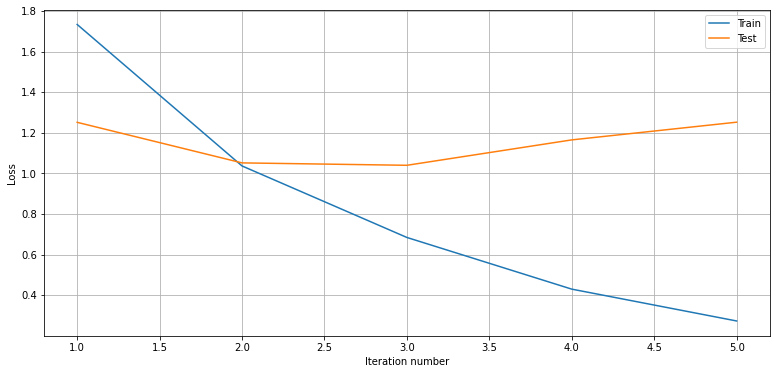

In [ ]:
plt.figure(figsize=(13, 6))
plt.plot([i+1 for i in range(N_EPOCHS)],SBERT_train_results["train_loss"].values.tolist(),label='Train')
plt.plot([i+1 for i in range(N_EPOCHS)], SBERT_train_results["test_loss"].values.tolist(),label='Test')
plt.legend()
plt.xlabel('Iteration number')
plt.ylabel('Loss')
plt.grid()
plt.show()

In [ ]:
%%time
teacher.to(device)
teacher.eval()

tr_tokens, train_logits, predicts, grounds = [], [],[],[]
batch = 400

for sku in tqdm(range(batch, len(data_filter), batch)):
    b_s = sentences[sku-batch:sku]
    tokens = [tokenizer.encode(
        sent, 
        add_special_tokens=True, 
        max_length=24, 
        pad_to_max_length='right') for sent in b_s]
    tr_tokens.extend(tokens)
    tokens = torch.tensor(tokens).to(device)
    with torch.no_grad():
        outputs = teacher(tokens)
    logits = outputs[0].detach().cpu().numpy()
    train_logits.extend(logits)
    preds = np.argmax(logits, axis=1)
    predicts.extend(preds)
    grounds.extend(labels[sku-batch:sku])

  0%|          | 0/124 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
100%|██████████| 124/124 [04:09<00:00,  2.01s/it]

CPU times: user 2min 8s, sys: 2min 1s, total: 4min 10s
Wall time: 4min 9s


In [ ]:
print(classification_report(grounds, predicts,target_names=category_index_reverce.values()))

                        precision    recall  f1-score   support

       BookAppointment       0.93      0.84      0.88      4964
       BuyEventTickets       0.84      0.86      0.85      4963
            FindEvents       0.88      0.95      0.91      4960
          FindProvider       0.96      0.86      0.91      4966
       FindRestaurants       0.85      0.96      0.90      4958
      GetCarsAvailable       0.98      0.94      0.96      4967
               GetRide       0.90      0.86      0.88      4959
           SearchHotel       0.78      0.95      0.86      4950
    SearchOnewayFlight       0.86      0.69      0.76      4951
SearchRoundtripFlights       0.79      0.81      0.80      4962

              accuracy                           0.87     49600
             macro avg       0.88      0.87      0.87     49600
          weighted avg       0.88      0.87      0.87     49600



In [ ]:
MODELS = ROOT / "model1"

In [ ]:
if not MODELS.exists():
    MODELS.mkdir(parents=True)

In [ ]:
teacher.save_pretrained(MODELS)

##Модели ученики


In [ ]:
class CNN(nn.Module):

    def __init__(self,
                 n_vocab,
                 n_labels,
                 embedding_dim=50,
                 n_filters=100,
                 filter_sizes=[3, 4, 5],
                 dropout=0.5,
                 special_chars=[],
                 pretrained_embeddings=None):  # TODO make number of conv layers configurable
        super(CNN, self).__init__()
        self.n_vocab = n_vocab
        self.n_labels = n_labels
        self.embedding_dim = embedding_dim
        self.n_filters = n_filters
        self.filter_sizes = filter_sizes
        self.dropout_p = dropout
        self.width = len(filter_sizes) * n_filters

        if pretrained_embeddings is not None:
            assert n_vocab == pretrained_embeddings.shape[0]
            assert embedding_dim == pretrained_embeddings.shape[1]
            self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings)
        else:
            self.embedding = nn.Embedding(n_vocab, embedding_dim)
        
        self.conv0 = nn.Conv2d(in_channels=1,
                               out_channels=n_filters,
                               kernel_size=(filter_sizes[0], embedding_dim))
        self.conv1 = nn.Conv2d(in_channels=1,
                               out_channels=n_filters,
                               kernel_size=(filter_sizes[1], embedding_dim))
        self.conv2 = nn.Conv2d(in_channels=1,
                               out_channels=n_filters,
                               kernel_size=(filter_sizes[2], embedding_dim))
        self.dropout = nn.Dropout(dropout)

        self.fc = nn.Linear(in_features=self.width, out_features=n_labels)

        for special in special_chars:
            self.embedding.weight.data[special] = torch.zeros(embedding_dim)

    def forward(self, input_ids):
        """Only input ids are required - kwargs are for API compat with BERT."""
        X = self.embedding(input_ids)
        X = X.unsqueeze(1)  # add single channel as dim 1
        X0 = F.relu(self.conv0(X).squeeze(3))
        X1 = F.relu(self.conv1(X).squeeze(3))
        X2 = F.relu(self.conv2(X).squeeze(3))
        X0 = F.max_pool1d(X0, X0.shape[2]).squeeze(2)
        X1 = F.max_pool1d(X1, X1.shape[2]).squeeze(2)
        X2 = F.max_pool1d(X2, X2.shape[2]).squeeze(2)
        X = torch.cat([X0, X1, X2], dim=1)
        X = self.dropout(X)
        X = self.fc(X)
        return X

In [ ]:
class LinearModel(nn.Module):
    
    def __init__(self, n_vocab, n_labels, embedding_dim, padding_idx):
        super(LinearModel, self).__init__()
        self.embeddings = nn.Embedding(n_vocab, embedding_dim, padding_idx=padding_idx)
        self.output = nn.Linear(embedding_dim, n_labels)
        with torch.no_grad():
            # FastText initializes embeddings with uniform distribution vs normal in PyTorch
            self.embeddings.weight.uniform_(to=1.0 / embedding_dim)
            self.embeddings.weight[padding_idx] = 0  # but FT doesn't have a padding token
            # FastText initializes output with zeros vs some random dist in PyTorch
            self.output.weight.zero_()

    def forward(self, input_ids):
        """Only input ids are required - kwargs are for API compat with BERT."""
        
        X = self.embeddings(input_ids)
        X = X.mean(dim=1)
        X = self.output(X)
        return X

In [ ]:
class BiLSTM(nn.Module):
    def __init__(self, n_vocabs, embed_dims, n_lstm_units, n_lstm_layers, n_output_classes,special_chars=[], use_dropout=True):
        super(BiLSTM, self).__init__()
        self.v = n_vocabs
        self.e = embed_dims
        self.u = n_lstm_units
        self.l = n_lstm_layers
        self.o = n_output_classes

        self.embed = nn.Embedding(
            self.v,
            self.e
            )
        self.bilstm = nn.LSTM(
            input_size = self.e,
            hidden_size = self.u,
            num_layers = self.l,
            batch_first = True,
            bidirectional = True,
            dropout=0.5 if use_dropout else 0.
        )
        self.dropout = nn.Dropout(0.5 if use_dropout else 0.)
        self.linear = nn.Linear(
            self.u * 2,
            self.o
        )
        for special in special_chars:
            self.embed.weight.data[special] = torch.zeros(embed_dims)
    def forward(self, X):
        h0 = torch.zeros(self.l * 2, X.size(0), self.u).to(device)
        c0 = torch.zeros(self.l * 2, X.size(0), self.u).to(device)

        out = self.embed(X)
        
        # NxTxh, lxNxh
        out, _ = self.bilstm(out, (h0, c0))
        # GMP
        out, _ = torch.max(out, 1)
        out = self.dropout(out)
        out = self.linear(out)
                
        return out

##Функции для обучения

 $L = \alpha L_{CE} + (1 - \alpha) L_{KLDiv}$ 

In [ ]:
@memory.cache(ignore=["teacher"]) 
def dataframe_to_dataset(df, teacher):
    max_len = 128
    features = tokenizer.batch_encode_plus(df.title.values.tolist(),
                                           max_length=max_len,
                                           pad_to_max_length=True,
                                           return_attention_mask=True,
                                           return_token_type_ids=True,
                                           return_tensors="pt")

    pre_dataset = TensorDataset(features["input_ids"],
                                features["attention_mask"],
                                features["token_type_ids"])
    teacher.to(device)
    teacher.eval()
    teacher_predictions = []
    for batch in tqdm(DataLoader(pre_dataset, batch_size=32, shuffle=False)):
        batch = tuple([b.to(device) for b in batch])
        inputs = {"input_ids": batch[0], "attention_mask": batch[1]}
        if teacher.base_model_prefix == "bert":
            inputs["token_type_ids"] = batch[2]
        with torch.no_grad():
            outputs = teacher(**inputs)
        teacher_predictions.append(outputs[0].to(torch.device("cpu")))  # put back on CPU

    dataset = TensorDataset(features["input_ids"],
                            features["attention_mask"],
                            features["token_type_ids"],
                            torch.tensor(df.label.astype("int").to_numpy(), dtype=torch.long),
                            torch.cat(teacher_predictions, axis=0))


    return dataset

In [ ]:
def train_epoch(train_iter, model, optim, epoch_num, distil=False,alpha = 0.5,temperature=10):
    train_loss = 0
    train_acc = 0
    y_true = []
    y_pred = []
    
    model.to(device)
    model.train()
    
    if distil:
        kldloss = nn.KLDivLoss()  
        cost = nn.CrossEntropyLoss()
    else:
        cost = nn.CrossEntropyLoss()

    for batch in tqdm(train_iter, total=len(train_iter), desc=f"Batch progress for epoch {epoch_num}"):
        
        batch = tuple([t.to(device) for t in batch])
        inputs = {"input_ids": batch[0],
                  "attention_mask": batch[1]}
        labels = batch[3]

        optim.zero_grad()
        
        student_logits = model(inputs.get('input_ids'))
        log_soft = F.log_softmax( student_logits / 1, dim=1 )
        log = student_logits
        soft_predictions = F.log_softmax( log / temperature, dim=1 )

        if distil:
            target = batch[4]
            tar = target.clone()
            teacher_logits = F.softmax( tar / temperature, dim=1 )
            distillation_loss = kldloss(soft_predictions, teacher_logits)
            target = labels
        else:
            target = labels

        batch_loss = cost(log_soft, target)


        if torch.isnan(batch_loss):
            print("NAN batch loss!", epoch_num, batch_loss, student_logits, target)
        if distil:
            train_loss += batch_loss.item()*(1-alpha) + distillation_loss.item()*(alpha)
        else:
            train_loss += batch_loss.item()

        batch_acc = (student_logits.argmax(1) == labels).sum().item()
        train_acc += batch_acc
        y_true.extend(labels.tolist())
        y_pred.extend(student_logits.argmax(1).tolist())

        batch_loss.backward()
        optim.step()

    return train_loss / len(train_iter), train_acc / len(train_iter.dataset), f1_score(y_true, y_pred, average="macro")  #

In [ ]:
def train_loop(model, optim, train_loader, test_loader, n_epochs=5, sched=None, distil=False,alpha = 0.5,temperature=10):
    training_results = {"epoch": list(range(n_epochs)),
                        "train_loss": [],
                        "train_acc": [],
                        "train_f1_macro": [],
                        "test_loss": [],
                        "test_acc": [],
                        "test_f1_macro": []}

    model.to(device)

    try:
        for i in range(n_epochs):
            
            train_loss, train_acc, train_f1 = train_epoch(train_loader, model, optim, epoch_num=i, distil=distil,alpha = alpha,temperature=temperature)
            if sched is not None:
                sched.step()
            test_loss, test_acc, test_f1 = validate(test_loader, model)
            training_results["train_loss"].append(train_loss)
            training_results["train_acc"].append(train_acc)
            training_results["train_f1_macro"].append(train_f1)
            training_results["test_loss"].append(test_loss)
            training_results["test_acc"].append(test_acc)
            training_results["test_f1_macro"].append(test_f1)
    except KeyboardInterrupt:
        pass

    return pd.DataFrame(training_results)

In [ ]:
def validate(test_iter, model):
    test_acc = 0 
    test_loss = 0
    y_true = []
    y_pred = []

    cost = nn.CrossEntropyLoss()

    model.to(device)
    model.eval()

    for batch in tqdm(test_iter, desc="Validating"):
        
        batch = tuple([t.to(device) for t in batch])
        inputs = {"input_ids": batch[0],
                  "attention_mask": batch[1],
                  "token_type_ids": batch[2]}
        labels = batch[3]

        with torch.no_grad():
            
            output = model(inputs.get('input_ids'))
            batch_loss = cost(output, labels)
            test_loss += batch_loss.item()
                    
            batch_acc = (output.argmax(1) == labels).sum().item() 
            test_acc += batch_acc
            y_true.extend(labels.tolist())
            y_pred.extend(output.argmax(1).tolist())
    print('Loss = {0}, Accuracy = {1}, F1-score = {2}'.format(test_loss / len(test_iter),test_acc / len(test_iter.dataset),f1_score(y_true, y_pred, average="macro")))
    return test_loss / len(test_iter), test_acc / len(test_iter.dataset), f1_score(y_true, y_pred, average="macro")  # classes are balanced

##Функции для проверки веса модели и скорости работы

In [ ]:
def print_size_of_model(model):
    torch.save(model.state_dict(), "temp.p")
    print('Size (MB):', os.path.getsize("temp.p")/1e6)
    os.remove('temp.p')

In [ ]:
from contextlib import contextmanager

@contextmanager
def single_thread():  
    num = torch.get_num_threads()
    torch.set_num_threads(1)
    yield
    torch.set_num_threads(num)

In [ ]:
def predict(model,text):
        max_len = 128
        l = []
        l.append(text)
        features = tokenizer.batch_encode_plus(l,
                                           max_length=max_len,
                                           pad_to_max_length=True,
                                           return_attention_mask=True,
                                           return_token_type_ids=True,
                                           return_tensors="pt")
        output = model(features['input_ids'].to(device))
        pred = F.softmax( output, dim=1 )
        ids = pred.argsort(1)[0].tolist()
        ids.reverse()
        return [(category_index_reverce[id], pred.tolist()[0][id]) for id in ids[:3]]

##Создаем учеников

In [ ]:
linear_model = LinearModel(n_vocab, N_LABELS, embedding_dim=EMBEDDING_DIM, padding_idx=padding_idx)

In [ ]:
cnn = CNN(n_vocab, N_LABELS, embedding_dim=EMBEDDING_DIM, special_chars=[padding_idx])

In [ ]:
bil = BiLSTM(n_vocabs=n_vocab,embed_dims=EMBEDDING_DIM,n_lstm_units = EMBEDDING_DIM/2,n_lstm_layers=1, n_output_classes =N_LABELS, special_chars=[padding_idx])

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


TypeError: ignored

##Готовим тестовый и проверочный датасеты

In [ ]:
train_frac = 0.8
split_idx = int(train_frac * len(data_filter))

train_df = data_filter[:split_idx]
test_df =data_filter[split_idx:]

train_dataset = dataframe_to_dataset(train_df, teacher)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)

test_dataset = dataframe_to_dataset(test_df, teacher)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

NameError: ignored

##Проверка работы моделей без дистилляции

In [ ]:
validate(test_loader, linear_model)

NameError: ignored

In [ ]:
%%timeit -r10

with single_thread():
    validate(test_loader, linear_model)

Validating: 100%|██████████| 313/313 [00:00<00:00, 1177.75it/s]

1 loop, best of 10: 277 ms per loop


In [ ]:
%%timeit -r10

with single_thread():
    print(validate(test_loader, cnn))

Validating:  21%|██▏       | 67/313 [00:00<00:00, 668.80it/s]

(1.1098637757971646, 0.6435, 0.6429838253619682)


Validating:  23%|██▎       | 73/313 [00:00<00:00, 729.73it/s]

(1.1098637757971646, 0.6435, 0.6429838253619682)


Validating:  23%|██▎       | 72/313 [00:00<00:00, 710.70it/s]

(1.1098637757971646, 0.6435, 0.6429838253619682)


Validating:  24%|██▍       | 75/313 [00:00<00:00, 744.26it/s]

(1.1098637757971646, 0.6435, 0.6429838253619682)


Validating:  23%|██▎       | 73/313 [00:00<00:00, 728.24it/s]

(1.1098637757971646, 0.6435, 0.6429838253619682)


Validating:  24%|██▍       | 75/313 [00:00<00:00, 745.39it/s]

(1.1098637757971646, 0.6435, 0.6429838253619682)


Validating:  24%|██▍       | 76/313 [00:00<00:00, 751.99it/s]

(1.1098637757971646, 0.6435, 0.6429838253619682)


Validating:  24%|██▍       | 75/313 [00:00<00:00, 745.93it/s]

(1.1098637757971646, 0.6435, 0.6429838253619682)


Validating:  24%|██▍       | 75/313 [00:00<00:00, 749.70it/s]

(1.1098637757971646, 0.6435, 0.6429838253619682)


Validating:  23%|██▎       | 73/313 [00:00<00:00, 729.29it/s]

(1.1098637757971646, 0.6435, 0.6429838253619682)


Validating: 100%|██████████| 313/313 [00:00<00:00, 717.26it/s]

(1.1098637757971646, 0.6435, 0.6429838253619682)
1 loop, best of 10: 454 ms per loop


In [ ]:
%%timeit -r10

with single_thread():
    validate(test_loader, cnn)

Validating: 100%|██████████| 313/313 [00:00<00:00, 762.13it/s]

1 loop, best of 10: 426 ms per loop


##Linear model


In [ ]:
N_EPOCHS = 5
alpha = 0.5

In [ ]:
linear_model = LinearModel(n_vocab, N_LABELS, embedding_dim=EMBEDDING_DIM, padding_idx=padding_idx)
optim = torch.optim.SGD(linear_model.parameters(), lr=LR)
sched = torch.optim.lr_scheduler.StepLR(optim, step_size=1, gamma=0.5)
linear_model_train_results = train_loop(linear_model, optim, train_loader, test_loader, N_EPOCHS, sched, distil=False, alpha = 0.5,temperature = 10)
linear_model_train_results["model"] = "Linear"
linear_model_train_results

Batch progress for epoch 1:   0%|          | 60/40000 [00:00<01:07, 595.52it/s]

Loss = 0.511004558624551, Accuracy = 0.8332, F1-score = 0.8343448242714816


Batch progress for epoch 2:   0%|          | 61/40000 [00:00<01:05, 605.52it/s]

Loss = 0.4338652831249344, Accuracy = 0.8555, F1-score = 0.8564750024339014


Batch progress for epoch 3:   0%|          | 60/40000 [00:00<01:07, 592.25it/s]

Loss = 0.40850507060940655, Accuracy = 0.8613, F1-score = 0.8620379523676929


Batch progress for epoch 4:   0%|          | 59/40000 [00:00<01:08, 585.73it/s]

Loss = 0.3943814073507778, Accuracy = 0.8658, F1-score = 0.8663839949205906


Validating: 100%|██████████| 313/313 [00:00<00:00, 1088.81it/s]


Loss = 0.38669489483578134, Accuracy = 0.8682, F1-score = 0.8687496015362116


,epoch,train_loss,train_acc,train_f1_macro,test_loss,test_acc,test_f1_macro,model
0,0,1.177482,0.571100,0.570708,0.511005,0.8332,0.834345,Linear
1,1,0.450894,0.846800,0.846243,0.433865,0.8555,0.856475,Linear
2,2,0.391905,0.863300,0.862762,0.408505,0.8613,0.862038,Linear
3,3,0.368277,0.870750,0.870247,0.394381,0.8658,0.866384,Linear
4,4,0.357230,0.874875,0.874390,0.386695,0.8682,0.868750,Linear


In [ ]:
linear_model = LinearModel(n_vocab, N_LABELS, embedding_dim=EMBEDDING_DIM, padding_idx=padding_idx)
optim = torch.optim.SGD(linear_model.parameters(), lr=LR)
sched = torch.optim.lr_scheduler.StepLR(optim, step_size=1, gamma=0.5)
linear_model_train_results = train_loop(linear_model, 
                                             optim, 
                                             train_loader, 
                                             test_loader, 
                                             N_EPOCHS, 
                                             sched, 
                                             distil=True, 
                                             alpha = 0.5,
                                             temperature = 10)
linear_model_train_results["model"] = "Linear"
linear_model_train_results

Batch progress for epoch 0:   0%|          | 0/40000 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:2611: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  "reduction: 'mean' divides the total loss by both the batch size and the support size."
Batch progress for epoch 1:   0%|          | 54/40000 [00:00<01:14, 534.78it/s]

Loss = 0.5117175499566446, Accuracy = 0.8314, F1-score = 0.8325285075154213


Batch progress for epoch 2:   0%|          | 53/40000 [00:00<01:15, 527.35it/s]

Loss = 0.43401093783374795, Accuracy = 0.8553, F1-score = 0.8562910467785396


Batch progress for epoch 3:   0%|          | 52/40000 [00:00<01:17, 512.42it/s]

Loss = 0.4082625872030045, Accuracy = 0.8605, F1-score = 0.8612085263849645


Batch progress for epoch 4:   0%|          | 54/40000 [00:00<01:14, 535.22it/s]

Loss = 0.3940491940076359, Accuracy = 0.8656, F1-score = 0.866170176874023


Validating: 100%|██████████| 313/313 [00:00<00:00, 1096.38it/s]


Loss = 0.38633462824760534, Accuracy = 0.8683, F1-score = 0.8687822653698314


,epoch,train_loss,train_acc,train_f1_macro,test_loss,test_acc,test_f1_macro,model
0,0,0.590384,0.570725,0.570307,0.511718,0.8314,0.832529,Linear
1,1,0.227974,0.846100,0.845536,0.434011,0.8553,0.856291,Linear
2,2,0.199185,0.863675,0.863120,0.408263,0.8605,0.861209,Linear
3,3,0.187666,0.870950,0.870442,0.394049,0.8656,0.866170,Linear
4,4,0.182281,0.875400,0.874921,0.386335,0.8683,0.868782,Linear


In [ ]:
linear_model = LinearModel(n_vocab, N_LABELS, embedding_dim=EMBEDDING_DIM, padding_idx=padding_idx)
optim = torch.optim.SGD(linear_model.parameters(), lr=LR)
sched = torch.optim.lr_scheduler.StepLR(optim, step_size=1, gamma=0.5)
linear_model_dist_train_results = train_loop(linear_model, 
                                             optim, 
                                             train_loader, 
                                             test_loader, 
                                             N_EPOCHS, 
                                             sched, 
                                             distil=True, 
                                             alpha = 1,
                                             temperature = 10)
linear_model_dist_train_results["model"] = "Linear"
linear_model_dist_train_results

Batch progress for epoch 0:   0%|          | 0/40000 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:2611: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  "reduction: 'mean' divides the total loss by both the batch size and the support size."
Batch progress for epoch 1:   0%|          | 55/40000 [00:00<01:13, 542.71it/s]

Loss = 0.5081122481404021, Accuracy = 0.8321, F1-score = 0.8332665829092993


Batch progress for epoch 2:   0%|          | 53/40000 [00:00<01:16, 521.06it/s]

Loss = 0.43148335209860206, Accuracy = 0.8554, F1-score = 0.8564197436398645


Batch progress for epoch 3:   0%|          | 56/40000 [00:00<01:12, 550.91it/s]

Loss = 0.40660741549139967, Accuracy = 0.8612, F1-score = 0.8619006664784624


Batch progress for epoch 4:   0%|          | 55/40000 [00:00<01:12, 548.28it/s]

Loss = 0.3927749747904345, Accuracy = 0.8649, F1-score = 0.8654663890757618


Validating: 100%|██████████| 313/313 [00:00<00:00, 1117.49it/s]


Loss = 0.38522661672518277, Accuracy = 0.8675, F1-score = 0.8680038723503127


,epoch,train_loss,train_acc,train_f1_macro,test_loss,test_acc,test_f1_macro,model
0,0,0.004374,0.570475,0.570037,0.508112,0.8321,0.833267,Linear
1,1,0.005841,0.846875,0.846330,0.431483,0.8554,0.856420,Linear
2,2,0.006902,0.863275,0.862738,0.406607,0.8612,0.861901,Linear
3,3,0.007383,0.871125,0.870625,0.392775,0.8649,0.865466,Linear
4,4,0.007615,0.875825,0.875326,0.385227,0.8675,0.868004,Linear


In [ ]:
linear_model = LinearModel(n_vocab, N_LABELS, embedding_dim=EMBEDDING_DIM, padding_idx=padding_idx)
optim = torch.optim.SGD(linear_model.parameters(), lr=LR)
sched = torch.optim.lr_scheduler.StepLR(optim, step_size=1, gamma=0.5)
linear_model_dist_train_results = train_loop(linear_model, 
                                             optim, 
                                             train_loader, 
                                             test_loader, 
                                             10, 
                                             sched, 
                                             distil=True, 
                                             alpha = 0.5,
                                             temperature = 10)
linear_model_dist_train_results["model"] = "Linear"
linear_model_dist_train_results

Batch progress for epoch 0:   0%|          | 0/40000 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:2611: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  "reduction: 'mean' divides the total loss by both the batch size and the support size."
Batch progress for epoch 1:   0%|          | 52/40000 [00:00<01:16, 518.86it/s]

Loss = 0.5101355766050351, Accuracy = 0.8321, F1-score = 0.8331934532446613


Batch progress for epoch 2:   0%|          | 56/40000 [00:00<01:11, 558.78it/s]

Loss = 0.43324778228998184, Accuracy = 0.854, F1-score = 0.8549531705235136


Batch progress for epoch 3:   0%|          | 55/40000 [00:00<01:13, 540.73it/s]

Loss = 0.40807883062968237, Accuracy = 0.8614, F1-score = 0.8620343057037957


Batch progress for epoch 4:   0%|          | 55/40000 [00:00<01:13, 541.77it/s]

Loss = 0.39402387971980884, Accuracy = 0.8644, F1-score = 0.8649370527501541


Batch progress for epoch 5:   0%|          | 53/40000 [00:00<01:15, 526.02it/s]

Loss = 0.38631627699151966, Accuracy = 0.8667, F1-score = 0.8671947770537896


Batch progress for epoch 6:   0%|          | 54/40000 [00:00<01:14, 537.55it/s]

Loss = 0.3831407031216941, Accuracy = 0.8676, F1-score = 0.8680342968395365


Batch progress for epoch 7:   0%|          | 56/40000 [00:00<01:11, 555.19it/s]

Loss = 0.3821043922973517, Accuracy = 0.8676, F1-score = 0.8680646876882896


Batch progress for epoch 8:   0%|          | 55/40000 [00:00<01:13, 544.38it/s]

Loss = 0.3817236299712818, Accuracy = 0.8664, F1-score = 0.866831704629093


Batch progress for epoch 9:   0%|          | 54/40000 [00:00<01:14, 534.12it/s]

Loss = 0.38153657221946474, Accuracy = 0.8667, F1-score = 0.8670993268464935


Validating: 100%|██████████| 313/313 [00:00<00:00, 1094.21it/s]


Loss = 0.3814492084966681, Accuracy = 0.867, F1-score = 0.8673995436169945


,epoch,train_loss,train_acc,train_f1_macro,test_loss,test_acc,test_f1_macro,model
0,0,0.591741,0.569825,0.569455,0.510136,0.8321,0.833193,Linear
1,1,0.228103,0.846100,0.845556,0.433248,0.8540,0.854953,Linear
2,2,0.199244,0.863525,0.862991,0.408079,0.8614,0.862034,Linear
3,3,0.187703,0.870925,0.870426,0.394024,0.8644,0.864937,Linear
4,4,0.182303,0.875275,0.874783,0.386316,0.8667,0.867195,Linear
5,5,0.179655,0.878050,0.877575,0.383141,0.8676,0.868034,Linear
6,6,0.178352,0.879000,0.878519,0.382104,0.8676,0.868065,Linear
7,7,0.177709,0.879575,0.879090,0.381724,0.8664,0.866832,Linear
8,8,0.177379,0.880075,0.879588,0.381537,0.8667,0.867099,Linear
9,9,0.177200,0.879775,0.879288,0.381449,0.8670,0.867400,Linear


In [ ]:
linear_model = LinearModel(n_vocab, N_LABELS, embedding_dim=EMBEDDING_DIM, padding_idx=padding_idx)
optim = torch.optim.SGD(linear_model.parameters(), lr=LR)
sched = torch.optim.lr_scheduler.StepLR(optim, step_size=1, gamma=0.5)
linear_model_dist_train_results = train_loop(linear_model, 
                                             optim, 
                                             train_loader, 
                                             test_loader, 
                                             N_EPOCHS, 
                                             sched, 
                                             distil=True, 
                                             alpha = 0.9,
                                             temperature = 10)
linear_model_dist_train_results["model"] = "Linear (distilled)"
linear_model_dist_train_results

Batch progress for epoch 0:   0%|          | 0/40000 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:2611: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  "reduction: 'mean' divides the total loss by both the batch size and the support size."
Batch progress for epoch 1:   0%|          | 55/40000 [00:00<01:13, 540.89it/s]

Loss = 0.5101809652563863, Accuracy = 0.8321, F1-score = 0.8333324294284938


Batch progress for epoch 2:   0%|          | 54/40000 [00:00<01:14, 538.38it/s]

Loss = 0.432344204772966, Accuracy = 0.8555, F1-score = 0.8565096669169814


Batch progress for epoch 3:   0%|          | 54/40000 [00:00<01:14, 536.41it/s]

Loss = 0.4072496478502362, Accuracy = 0.8611, F1-score = 0.861780598563057


Batch progress for epoch 4:   0%|          | 57/40000 [00:00<01:11, 561.49it/s]

Loss = 0.3933134316303098, Accuracy = 0.8646, F1-score = 0.8651570282019749


Validating: 100%|██████████| 313/313 [00:00<00:00, 1108.26it/s]


Loss = 0.38572639148361004, Accuracy = 0.8677, F1-score = 0.8681977171050625


,epoch,train_loss,train_acc,train_f1_macro,test_loss,test_acc,test_f1_macro,model
0,0,0.122021,0.569025,0.568582,0.510181,0.8321,0.833332,Linear (distilled)
1,1,0.050194,0.846500,0.845942,0.432344,0.8555,0.856510,Linear (distilled)
2,2,0.045303,0.863350,0.862816,0.407250,0.8611,0.861781,Linear (distilled)
3,3,0.043398,0.870725,0.870220,0.393313,0.8646,0.865157,Linear (distilled)
4,4,0.042513,0.875400,0.874906,0.385726,0.8677,0.868198,Linear (distilled)


In [ ]:
validate(test_loader, linear_model)

Validating: 100%|██████████| 313/313 [00:00<00:00, 1094.39it/s]


(1.2993624817829925, 0.5754, 0.5683372134932979)

In [ ]:
%%timeit -r10

with single_thread():
    validate(test_loader, linear_model_dist)

In [ ]:
validate(test_loader, linear_model_dist)

Validating: 100%|██████████| 313/313 [00:00<00:00, 1110.75it/s]


(1.2930294745646345, 0.5789, 0.5719708062868887)

In [ ]:
%%timeit -r10

with single_thread():
    validate(test_loader, linear_model_dist)

Validating: 100%|██████████| 313/313 [00:00<00:00, 1177.21it/s]

1 loop, best of 10: 280 ms per loop


##CNN

In [ ]:
train_loader = DataLoader(dataframe_to_dataset(train_df, teacher), batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
cnn = CNN(n_vocab, N_LABELS, embedding_dim=EMBEDDING_DIM, special_chars=[padding_idx])
optim = torch.optim.Adam(cnn.parameters())
cnn_train_results = train_loop(cnn, optim, train_loader, test_loader, n_epochs=5, sched=None, distil=False,alpha = 0,temperature = 10)
cnn_train_results["model"] = "CNN"
cnn_train_results

Batch progress for epoch 1:   1%|          | 13/1250 [00:00<00:09, 128.59it/s]

Loss = 0.45329414936490714, Accuracy = 0.8473, F1-score = 0.847633929438957


Batch progress for epoch 2:   1%|          | 13/1250 [00:00<00:09, 126.38it/s]

Loss = 0.3779542941016892, Accuracy = 0.864, F1-score = 0.8642058317632058


Batch progress for epoch 3:   1%|          | 14/1250 [00:00<00:09, 133.83it/s]

Loss = 0.3549783536420463, Accuracy = 0.8722, F1-score = 0.8724441182086007


Batch progress for epoch 4:   1%|          | 14/1250 [00:00<00:09, 135.48it/s]

Loss = 0.3462349116897431, Accuracy = 0.8749, F1-score = 0.8753909340528285


Validating: 100%|██████████| 313/313 [00:00<00:00, 718.87it/s]

Loss = 0.33796525090790025, Accuracy = 0.8757, F1-score = 0.8761634156117613


,epoch,train_loss,train_acc,train_f1_macro,test_loss,test_acc,test_f1_macro,model
0,0,0.949113,0.674825,0.674015,0.453294,0.8473,0.847634,CNN
1,1,0.491196,0.827850,0.827376,0.377954,0.8640,0.864206,CNN
2,2,0.402858,0.855525,0.855156,0.354978,0.8722,0.872444,CNN
3,3,0.350855,0.871950,0.871603,0.346235,0.8749,0.875391,CNN
4,4,0.321102,0.882175,0.881887,0.337965,0.8757,0.876163,CNN


In [ ]:
optim = torch.optim.Adam(cnn.parameters())

cnn_train_results = train_loop(cnn, optim, train_loader, test_loader, n_epochs=N_EPOCHS, sched=None, distil=False,alpha = 0.5,temperature = 10)
cnn_train_results["model"] = "CNN"
cnn_train_results

Batch progress for epoch 1:   1%|          | 14/1250 [00:00<00:09, 133.25it/s]

Loss = 0.343627557170372, Accuracy = 0.8768, F1-score = 0.8773044415886335


Batch progress for epoch 2:   1%|          | 14/1250 [00:00<00:09, 134.71it/s]

Loss = 0.3388307679611178, Accuracy = 0.8781, F1-score = 0.8785404105195646


Batch progress for epoch 3:   1%|          | 13/1250 [00:00<00:09, 128.22it/s]

Loss = 0.35246123371128074, Accuracy = 0.8769, F1-score = 0.8779099273138421


Batch progress for epoch 4:   1%|          | 14/1250 [00:00<00:09, 133.17it/s]

Loss = 0.35443122984883124, Accuracy = 0.8817, F1-score = 0.8821577227706818


Validating: 100%|██████████| 313/313 [00:00<00:00, 734.41it/s]

Loss = 0.3597903197107557, Accuracy = 0.8786, F1-score = 0.8792438700948162


,epoch,train_loss,train_acc,train_f1_macro,test_loss,test_acc,test_f1_macro,model
0,0,0.300892,0.886875,0.886615,0.343628,0.8768,0.877304,CNN
1,1,0.280141,0.895500,0.895271,0.338831,0.8781,0.878540,CNN
2,2,0.261339,0.900775,0.900553,0.352461,0.8769,0.877910,CNN
3,3,0.252202,0.904600,0.904403,0.354431,0.8817,0.882158,CNN
4,4,0.242569,0.907725,0.907535,0.359790,0.8786,0.879244,CNN


In [ ]:
optim = torch.optim.Adam(cnn.parameters())

cnn_dist_train_results = train_loop(cnn, optim, train_loader, test_loader, n_epochs=N_EPOCHS, sched=None, distil=True,alpha = 0.9,temperature = 10)
cnn_dist_train_results["model"] = "CNN"
cnn_dist_train_results

Batch progress for epoch 0:   0%|          | 0/1250 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:2611: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  "reduction: 'mean' divides the total loss by both the batch size and the support size."
Batch progress for epoch 1:   1%|          | 13/1250 [00:00<00:09, 129.23it/s]

Loss = 0.3662169666919179, Accuracy = 0.8801, F1-score = 0.8808145673881931


Batch progress for epoch 2:   1%|          | 14/1250 [00:00<00:09, 131.78it/s]

Loss = 0.3755757256675833, Accuracy = 0.8797, F1-score = 0.8802187226930993


Batch progress for epoch 3:   1%|          | 14/1250 [00:00<00:09, 130.69it/s]

Loss = 0.37777779651835514, Accuracy = 0.8787, F1-score = 0.8793003903244498


Batch progress for epoch 4:   1%|          | 14/1250 [00:00<00:09, 131.29it/s]

Loss = 0.3880119791593605, Accuracy = 0.8803, F1-score = 0.8809385636740659


Validating: 100%|██████████| 313/313 [00:00<00:00, 721.88it/s]

Loss = 0.39951303322165727, Accuracy = 0.8795, F1-score = 0.880164382810045


,epoch,train_loss,train_acc,train_f1_macro,test_loss,test_acc,test_f1_macro,model
0,0,0.049825,0.910900,0.910764,0.366217,0.8801,0.880815,CNN
1,1,0.052723,0.916000,0.915865,0.375576,0.8797,0.880219,CNN
2,2,0.055477,0.917500,0.917367,0.377778,0.8787,0.879300,CNN
3,3,0.059311,0.919725,0.919622,0.388012,0.8803,0.880939,CNN
4,4,0.062928,0.920750,0.920685,0.399513,0.8795,0.880164,CNN


In [ ]:
optim = torch.optim.Adam(cnn.parameters())

cnn_dist_train_results = train_loop(cnn, optim, train_loader, test_loader, n_epochs=N_EPOCHS, sched=None, distil=True,alpha = 1,temperature = 10)
cnn_dist_train_results["model"] = "CNN"
cnn_dist_train_results

Batch progress for epoch 0:   0%|          | 0/1250 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:2611: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  "reduction: 'mean' divides the total loss by both the batch size and the support size."
Batch progress for epoch 1:   1%|          | 14/1250 [00:00<00:09, 131.84it/s]

Loss = 0.4123328050818687, Accuracy = 0.8812, F1-score = 0.8817766523796665


Batch progress for epoch 2:   1%|          | 13/1250 [00:00<00:09, 125.69it/s]

Loss = 0.4278035683158678, Accuracy = 0.88, F1-score = 0.8809261397280546


Batch progress for epoch 3:   1%|          | 13/1250 [00:00<00:09, 129.81it/s]

Loss = 0.44194484171204673, Accuracy = 0.8752, F1-score = 0.8759909271854506


Batch progress for epoch 4:   1%|          | 14/1250 [00:00<00:09, 131.38it/s]

Loss = 0.4475077732730978, Accuracy = 0.8774, F1-score = 0.8783214911929784


Validating: 100%|██████████| 313/313 [00:00<00:00, 721.02it/s]

Loss = 0.4636354479974451, Accuracy = 0.8767, F1-score = 0.8775376783067432


,epoch,train_loss,train_acc,train_f1_macro,test_loss,test_acc,test_f1_macro,model
0,0,0.056354,0.924525,0.924416,0.412333,0.8812,0.881777,CNN
1,1,0.061984,0.926600,0.926500,0.427804,0.8800,0.880926,CNN
2,2,0.065855,0.928975,0.928891,0.441945,0.8752,0.875991,CNN
3,3,0.072195,0.928775,0.928689,0.447508,0.8774,0.878321,CNN
4,4,0.075959,0.931250,0.931151,0.463635,0.8767,0.877538,CNN


In [ ]:
print_size_of_model(cnn)

Size (MB): 24.165696


##LSTM

In [ ]:
class BiLSTM(nn.Module):
    def __init__(self, n_vocabs, embed_dims, n_lstm_units, n_lstm_layers, n_output_classes,special_chars=[], use_dropout=True):
        super(BiLSTM, self).__init__()
        self.v = n_vocabs
        self.e = embed_dims
        self.u = n_lstm_units
        self.l = n_lstm_layers
        self.o = n_output_classes

        self.embed = nn.Embedding(
            self.v,
            self.e
            )
        self.bilstm = nn.LSTM(
            input_size = self.e,
            hidden_size = self.u,
            num_layers = self.l,
            batch_first = True,
            bidirectional = True,
            dropout=0.5 if use_dropout else 0.
        )
        self.dropout = nn.Dropout(0.5 if use_dropout else 0.)
        self.linear = nn.Linear(
            self.u * 2,
            self.o
        )
        for special in special_chars:
            self.embed.weight.data[special] = torch.zeros(embed_dims)
    def forward(self, X):
        h0 = torch.zeros(self.l * 2, X.size(0), self.u).to(device)
        c0 = torch.zeros(self.l * 2, X.size(0), self.u).to(device)

        out = self.embed(X)
        
        # NxTxh, lxNxh
        out, _ = self.bilstm(out, (h0, c0))
        # GMP
        out, _ = torch.max(out, 1)
        out = self.dropout(out)
        out = self.linear(out)
                
        return out

In [ ]:
bil = BiLSTM(n_vocabs=n_vocab,embed_dims=50,n_lstm_units = 25,n_lstm_layers=1, n_output_classes =10, special_chars=[padding_idx])
bil.to(device)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


BiLSTM(
  (embed): Embedding(119547, 50)
  (bilstm): LSTM(50, 25, batch_first=True, dropout=0.5, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (linear): Linear(in_features=50, out_features=10, bias=True)
)

In [ ]:
validate(test_loader, bil)

Validating: 100%|██████████| 313/313 [00:01<00:00, 241.69it/s]

Loss = 2.3156758063136578, Accuracy = 0.0977, F1-score = 0.0228558757405885


(2.3156758063136578, 0.0977, 0.0228558757405885)

In [ ]:
train_loader = DataLoader(dataframe_to_dataset(train_df, teacher), batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
bil = BiLSTM(n_vocabs=n_vocab,embed_dims=50,n_lstm_units = 25,n_lstm_layers=1, n_output_classes =10, special_chars=[padding_idx])
optim = torch.optim.Adam(bil.parameters(),lr = 0.0001)
#sched = torch.optim.lr_scheduler.StepLR(optim, step_size=1, gamma=0.5)
lstm_train_results = train_loop(bil, optim, train_loader, test_loader, n_epochs=10, sched=None, distil=True, alpha = 0.9, temperature=10)
lstm_train_results["model"] = "LSTM"
lstm_train_results

Batch progress for epoch 0:   0%|          | 0/1250 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:2611: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  "reduction: 'mean' divides the total loss by both the batch size and the support size."
Batch progress for epoch 1:   1%|          | 10/1250 [00:00<00:13, 91.11it/s]

Loss = 0.9582082347367138, Accuracy = 0.7568, F1-score = 0.7579017864088523


Batch progress for epoch 2:   1%|          | 10/1250 [00:00<00:12, 95.62it/s]

Loss = 0.8421074414786439, Accuracy = 0.7713, F1-score = 0.7720941235963004


Batch progress for epoch 3:   1%|          | 10/1250 [00:00<00:13, 94.23it/s]

Loss = 0.765531373195374, Accuracy = 0.7833, F1-score = 0.7843241805004818


Batch progress for epoch 4:   1%|          | 10/1250 [00:00<00:12, 95.45it/s]

Loss = 0.7073272531405805, Accuracy = 0.7945, F1-score = 0.7954839209079809


Batch progress for epoch 5:   1%|          | 10/1250 [00:00<00:12, 97.60it/s]

Loss = 0.6590143017494641, Accuracy = 0.8031, F1-score = 0.8037745683043893


Batch progress for epoch 6:   1%|          | 10/1250 [00:00<00:12, 96.40it/s]

Loss = 0.619712546991464, Accuracy = 0.8112, F1-score = 0.8118950246363174


Batch progress for epoch 7:   1%|          | 10/1250 [00:00<00:13, 95.21it/s]

Loss = 0.587927942458814, Accuracy = 0.8174, F1-score = 0.8179137415064567


Batch progress for epoch 8:   1%|          | 10/1250 [00:00<00:12, 95.64it/s]

Loss = 0.5616999240919424, Accuracy = 0.8243, F1-score = 0.8248913648052122


Batch progress for epoch 9:   1%|          | 10/1250 [00:00<00:12, 96.96it/s]

Loss = 0.5384355351186028, Accuracy = 0.8291, F1-score = 0.8295957989511165


Validating: 100%|██████████| 313/313 [00:01<00:00, 244.46it/s]


Loss = 0.5217706523002527, Accuracy = 0.8284, F1-score = 0.8287860350835995


,epoch,train_loss,train_acc,train_f1_macro,test_loss,test_acc,test_f1_macro,model
0,0,0.118074,0.650575,0.649722,0.958208,0.7568,0.757902,LSTM
1,1,0.105226,0.680825,0.679877,0.842107,0.7713,0.772094,LSTM
2,2,0.095783,0.703025,0.702602,0.765531,0.7833,0.784324,LSTM
3,3,0.089238,0.722300,0.721438,0.707327,0.7945,0.795484,LSTM
4,4,0.083345,0.738400,0.737443,0.659014,0.8031,0.803775,LSTM
5,5,0.078711,0.753400,0.752559,0.619713,0.8112,0.811895,LSTM
6,6,0.074596,0.763550,0.762745,0.587928,0.8174,0.817914,LSTM
7,7,0.071377,0.775650,0.774704,0.561700,0.8243,0.824891,LSTM
8,8,0.068255,0.785250,0.784446,0.538436,0.8291,0.829596,LSTM
9,9,0.066440,0.789900,0.788851,0.521771,0.8284,0.828786,LSTM


In [ ]:
bil = BiLSTM(n_vocabs=n_vocab,embed_dims=50,n_lstm_units = 25,n_lstm_layers=1, n_output_classes =10, special_chars=[padding_idx])
optim = torch.optim.Adam(bil.parameters(),lr = 0.0001)
#sched = torch.optim.lr_scheduler.StepLR(optim, step_size=1, gamma=0.5)
lstm_train_results = train_loop(bil, optim, train_loader, test_loader, n_epochs=10, sched=None, distil=True, alpha = 0, temperature=10)
lstm_train_results["model"] = "LSTM"
lstm_train_results

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
Batch progress for epoch 0:   0%|          | 0/1250 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:2611: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  "reduction: 'mean' divides the total loss by both the batch size and the support size."
Batch progress for epoch 1:   1%|          | 10/1250 [00:00<00:12, 95.65it/s]

Loss = 2.187003169958584, Accuracy = 0.4509, F1-score = 0.4365879743073894


Batch progress for epoch 2:   1%|          | 10/1250 [00:00<00:13, 92.51it/s]

Loss = 2.0041684327415004, Accuracy = 0.6002, F1-score = 0.5947534103593487


Batch progress for epoch 3:   1%|          | 10/1250 [00:00<00:13, 94.26it/s]

Loss = 1.6967995806623952, Accuracy = 0.6661, F1-score = 0.6674027066079301


Batch progress for epoch 4:   1%|          | 10/1250 [00:00<00:12, 95.44it/s]

Loss = 1.3350752554000758, Accuracy = 0.6986, F1-score = 0.7010164640709319


Batch progress for epoch 5:   1%|          | 10/1250 [00:00<00:13, 93.77it/s]

Loss = 1.077068668584854, Accuracy = 0.7306, F1-score = 0.7327235750503782


Batch progress for epoch 6:   1%|          | 9/1250 [00:00<00:14, 86.94it/s]

Loss = 0.9234424709512022, Accuracy = 0.7538, F1-score = 0.7556989184392163


Batch progress for epoch 7:   1%|          | 10/1250 [00:00<00:12, 95.64it/s]

Loss = 0.818408042097244, Accuracy = 0.7727, F1-score = 0.7743450034598953


Batch progress for epoch 8:   1%|          | 10/1250 [00:00<00:12, 95.94it/s]

Loss = 0.7518483504129294, Accuracy = 0.7849, F1-score = 0.7868251922210574


Batch progress for epoch 9:   1%|          | 10/1250 [00:00<00:12, 95.97it/s]

Loss = 0.6950979416553205, Accuracy = 0.7953, F1-score = 0.7969612333924234


Validating: 100%|██████████| 313/313 [00:01<00:00, 244.54it/s]


Loss = 0.6505018982072227, Accuracy = 0.8045, F1-score = 0.8062289283747825


,epoch,train_loss,train_acc,train_f1_macro,test_loss,test_acc,test_f1_macro,model
0,0,2.268061,0.154100,0.147743,2.187003,0.4509,0.436588,LSTM
1,1,2.125488,0.301275,0.293328,2.004168,0.6002,0.594753,LSTM
2,2,1.898582,0.448700,0.443459,1.696800,0.6661,0.667403,LSTM
3,3,1.577305,0.551325,0.548142,1.335075,0.6986,0.701016,LSTM
4,4,1.292077,0.616575,0.614976,1.077069,0.7306,0.732724,LSTM
5,5,1.104831,0.661725,0.660639,0.923442,0.7538,0.755699,LSTM
6,6,0.984098,0.695025,0.694028,0.818408,0.7727,0.774345,LSTM
7,7,0.903197,0.714550,0.713142,0.751848,0.7849,0.786825,LSTM
8,8,0.837802,0.730800,0.729784,0.695098,0.7953,0.796961,LSTM
9,9,0.786612,0.746625,0.745769,0.650502,0.8045,0.806229,LSTM


In [ ]:
bil = BiLSTM(n_vocabs=n_vocab,embed_dims=50,n_lstm_units = 25,n_lstm_layers=1, n_output_classes =10, special_chars=[padding_idx])
optim = torch.optim.Adam(bil.parameters(),lr = 0.0001)
#sched = torch.optim.lr_scheduler.StepLR(optim, step_size=1, gamma=0.5)
lstm_train_results = train_loop(bil, optim, train_loader, test_loader, n_epochs=10, sched=None, distil=True, alpha = 0.5, temperature=10)
lstm_train_results["model"] = "LSTM"
lstm_train_results

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
Batch progress for epoch 0:   0%|          | 0/1250 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:2611: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  "reduction: 'mean' divides the total loss by both the batch size and the support size."
Batch progress for epoch 1:   1%|          | 10/1250 [00:00<00:13, 90.92it/s]

Loss = 2.212771271745237, Accuracy = 0.4424, F1-score = 0.43763499941581874


Batch progress for epoch 2:   1%|          | 10/1250 [00:00<00:13, 94.36it/s]

Loss = 2.049230362660588, Accuracy = 0.6108, F1-score = 0.6019078151374122


Batch progress for epoch 3:   1%|          | 10/1250 [00:00<00:12, 95.62it/s]

Loss = 1.7968654941065243, Accuracy = 0.668, F1-score = 0.6612237222565087


Batch progress for epoch 4:   1%|          | 10/1250 [00:00<00:12, 95.67it/s]

Loss = 1.4548262079683736, Accuracy = 0.7004, F1-score = 0.6954575457332919


Batch progress for epoch 5:   1%|          | 10/1250 [00:00<00:13, 93.80it/s]

Loss = 1.1346018499078843, Accuracy = 0.7356, F1-score = 0.7343275706303882


Batch progress for epoch 6:   1%|          | 10/1250 [00:00<00:13, 94.37it/s]

Loss = 0.9456764259658301, Accuracy = 0.7567, F1-score = 0.7567787063450513


Batch progress for epoch 7:   1%|          | 9/1250 [00:00<00:13, 89.35it/s]

Loss = 0.817848021420427, Accuracy = 0.7703, F1-score = 0.7706572406808169


Batch progress for epoch 8:   1%|          | 9/1250 [00:00<00:14, 88.51it/s]

Loss = 0.7339033628233705, Accuracy = 0.784, F1-score = 0.7849453568969447


Batch progress for epoch 9:   1%|          | 10/1250 [00:00<00:13, 94.99it/s]

Loss = 0.6830381526352879, Accuracy = 0.7951, F1-score = 0.7957492673330705


Validating: 100%|██████████| 313/313 [00:01<00:00, 247.24it/s]

Loss = 0.6394845095876688, Accuracy = 0.8011, F1-score = 0.8019679158993849


,epoch,train_loss,train_acc,train_f1_macro,test_loss,test_acc,test_f1_macro,model
0,0,1.145811,0.139350,0.132246,2.212771,0.4424,0.437635,LSTM
1,1,1.081517,0.279725,0.276086,2.049230,0.6108,0.601908,LSTM
2,2,0.983939,0.421100,0.411777,1.796865,0.6680,0.661224,LSTM
3,3,0.846776,0.532675,0.520706,1.454826,0.7004,0.695458,LSTM
4,4,0.686018,0.613275,0.604796,1.134602,0.7356,0.734328,LSTM
5,5,0.572996,0.663675,0.659908,0.945676,0.7567,0.756779,LSTM
6,6,0.502631,0.695675,0.693622,0.817848,0.7703,0.770657,LSTM
7,7,0.453239,0.716050,0.714683,0.733903,0.7840,0.784945,LSTM
8,8,0.421438,0.731875,0.730307,0.683038,0.7951,0.795749,LSTM
9,9,0.393350,0.746275,0.744749,0.639485,0.8011,0.801968,LSTM


In [ ]:
validate(test_loader, bil)

Validating: 100%|██████████| 313/313 [00:01<00:00, 251.10it/s]


(2.183135775331491, 0.2735, 0.2520042828705722)

In [ ]:
%%timeit -r10

with single_thread():
    validate(test_loader, bil)

Validating: 100%|██████████| 313/313 [00:01<00:00, 260.82it/s]

1 loop, best of 10: 1.21 s per loop


In [ ]:
bil_dist = BiLSTM(n_vocabs=n_vocab,embed_dims=50,n_lstm_units = 25,n_lstm_layers=1, n_output_classes =10, special_chars=[padding_idx])
bil.to(device)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


BiLSTM(
  (embed): Embedding(119547, 50)
  (bilstm): LSTM(50, 25, batch_first=True, dropout=0.5, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (linear): Linear(in_features=50, out_features=10, bias=True)
)

In [ ]:
%%timeit -r10

with single_thread():
    validate(test_loader, bil_dist)

Validating: 100%|██████████| 313/313 [00:01<00:00, 252.54it/s]

1 loop, best of 10: 1.23 s per loop


In [ ]:
optim = torch.optim.Adam(bil_dist.parameters(),lr = 0.0001)
#sched = torch.optim.lr_scheduler.StepLR(optim, step_size=1, gamma=0.5)
cnn_train_results = train_loop(bil_dist, optim, train_loader, test_loader, n_epochs=N_EPOCHS, sched=None, distil=True, alpha = 0, temperature=10)
cnn_train_results["model"] = "LSTM"
cnn_train_results

Batch progress for epoch 0:   0%|          | 0/1250 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:2611: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  "reduction: 'mean' divides the total loss by both the batch size and the support size."
Validating: 100%|██████████| 313/313 [00:01<00:00, 247.72it/s]


,epoch,train_loss,train_acc,train_f1_macro,test_loss,test_acc,test_f1_macro,model
0,0,2.314721,0.106050,0.098226,2.290046,0.1530,0.138162,LSTM
1,1,2.289922,0.132200,0.128725,2.270503,0.2013,0.179642,LSTM
2,2,2.270370,0.155875,0.149248,2.250525,0.2367,0.216539,LSTM
3,3,2.247231,0.177600,0.169511,2.227586,0.2657,0.248477,LSTM
4,4,2.224827,0.197375,0.188602,2.201043,0.2821,0.265639,LSTM


In [ ]:
validate(test_loader, bil_dist)

Validating: 100%|██████████| 313/313 [00:01<00:00, 247.74it/s]


(2.026452616761668, 0.2555, 0.18224359486330463)

In [ ]:
%%timeit -r10

with single_thread():
    validate(test_loader, bil_dist)

Validating: 100%|██████████| 313/313 [00:01<00:00, 252.63it/s]

1 loop, best of 10: 1.22 s per loop


##Графики

In [ ]:
training_results = pd.concat([linear_model_train_results,                             
                              cnn_dist_train_results,
                              lstm_train_results])

In [ ]:
training_results.query("epoch == 4").set_index("model")[["test_acc", "test_f1_macro"]]

,test_acc,test_f1_macro
model,,
Linear,0.8683,0.868782
CNN,0.8767,0.877538
LSTM,0.7356,0.734328


In [ ]:
alt.Chart(training_results).mark_line().encode(
    x="epoch:Q",
    y="test_f1_macro:Q",
    color="model"
)

alt.Chart(...)